#  Modelo de ZeeHB

Sample of notebook for specific model

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import numpy as np
import os, sys, inspect
import commands
import hep as hp

In [3]:
def func(s2phi, M1, M2, MAo, Mho, MHo, v, lam2, lam3, lam6, lam7, lam8, lam9, lam10, lamh):
    M12 = M1*M1; M22 = M2*M2; MAo2 = MAo*MAo; Mho2 = Mho*Mho; MHo2 = MHo*MHo;
    k = s2phi*np.log(M22/float(M12))/(4.*np.pi)**2
    phi = 0.5*np.arcsin(s2phi)
    Mu  = (M22-M12)*s2phi/(np.sqrt(2.0)*v)
    MH2 = M12*(np.sin(phi))**2+M22*(np.cos(phi))**2
    M332 = M12*(np.cos(phi))**2+M22*(np.sin(phi))**2
    lam1 = 0.5*(MHo2+Mho2-np.sqrt((MHo2-Mho2)**2-4.0*v**4*lam6**2))/(v**2)
    Mu22 = MH2-0.5*lam3*(v**2)
    Muh2 = M332-0.5*lam8*(v**2)
    lam4 = 0.5*(np.sqrt((MHo2-Mho2)**2-4.0*v**4*lam6**2)+MHo2+Mho2+2.0*(MAo2-2.0*MH2))/(v**2)
    lam5 = 0.5*(np.sqrt((MHo2-Mho2)**2-4.0*v**4*lam6**2)+MHo2+Mho2-2.0*MAo2)/(v**2)    
    return k, Mu, Muh2, Mu22, lam1, lam4, lam5

In [4]:
def Kappa(s2phi,M1,M2):
    return s2phi*np.log(M2**2/M1**2)/(4.*np.pi)**2

def Inverse_Zee_Matrix(kappa,ml,IH=False,sgnm2=-1,sgnml=1):
    """Inverse neutrino mass matrix normalized by kappa from
        Mnu_diag=U^T.(kappa Y).U
        ,
        (Inverse_Zee_Matrix) = U. Mnu_diag.U^T/kappa
        sgnm2=-1 guarantees real Yukawa couplings
        
    requires hep.py:
       https://github.com/restrepo/BSM-Toolbox/blob/master/tests/hep.py
    """
    if not IH:
        mltmp,Dm21_2,Dm3l_2,theta12,theta23,theta13,delta=hp.neutrino_data()
        U=hp.UPMNS(theta12[1],theta13[1],theta23[1])
        m1=ml; m2=sgnm2*np.sqrt(Dm21_2[1]+m1**2); m3=sgnml*np.sqrt(Dm3l_2[1]+m1**2)
    else:
        mltmp,Dm21_2,Dm3l_2,theta12,theta23,theta13,delta=hp.neutrino_data(IH=True)
        U=hp.UPMNS(theta12[1],theta13[1],theta23[1])
        #DEBUG signs
        m3=ml; m2=sgnm2*np.sqrt(Dm3l_2[1]-m3**2); m1=sign*ml*np.sqrt(Dm21_2[1]-m2**2)
        
    return np.dot( np.dot( U,np.diag([m1,m2,m3]) ), U.transpose() )/kappa

def get_yukawas(X,q01=1e-3,q02=1e-6,q10=200e-3,q12=0,q21=-1e-5,q22=0,m_e=0.5109989461e-3,m_mu=0.1056583745,m_tau=1.77686):
    """
    Get the O and f full Yukawa mass matrices which define the neutrino mass matrix in the Zee model
      Mnu=kappa*(O.M_lep.f^T+f.M_lep.O^T)
    where M_lep is the diagonal matrix with the charged leptons
    
    The input X is the output of the `def Inverse_Zee_Matrix(...)` in this module
    """
    import numpy.lib.scimath as sc # .sqrt -> returns complex for sqrt(negative real)
    ml=np.array([m_e,m_mu,m_tau])
    Q=np.zeros((3,3))
    f=np.zeros((3,3))
    Q[0,1]=q01;Q[0,2]=q02;Q[1,0]=q10;Q[1,2]=q12;Q[2,1]=q21;Q[2,2]=q22
    Q[2,0]=( -(ml[0]**3*Q[1,0]**2*X[0,0]**2*(ml[1]*Q[2,1]*X[0,1] + ml[2]*Q[0,2]*X[2,2])) -\
      ml[0]*(ml[1]*Q[2,1]*X[1,1] + ml[2]*Q[1,2]*X[2,2])*(ml[1]*Q[0,1]*((ml[1]*Q[0,1]*X[0,1] +\
      ml[2]*Q[0,2]*X[0,2])*X[1,1] + ml[2]*Q[1,2]*X[0,0]*X[1,2]) +\
      ml[2]**2*Q[0,2]*Q[1,2]*X[0,0]*X[2,2]) + ml[0]**2*Q[1,0]*X[0,0]*(-(ml[1]*Q[2,1]*((2*ml[1]*Q[0,1]*X[0,1] +\
      ml[2]*Q[0,2]*X[0,2])*X[1,1] + ml[2]*Q[1,2]*X[0,0]*X[1,2])) -\
      ml[2]*(2*ml[2]*Q[0,2]*Q[1,2]*X[0,2] + ml[1]*Q[0,1]*(Q[1,2]*X[0,1] + Q[0,2]*X[1,1]))*X[2,2]) +\
      np.sqrt( -(ml[0]**2*ml[1]**2*(ml[0]*Q[1,0]*Q[2,1]*X[0,0] + Q[0,1]*(ml[1]*Q[2,1]*X[1,1] +\
      ml[2]*Q[1,2]*X[2,2]))**2*(ml[0]**2*Q[1,0]**2*X[0,0]**2*(-X[0,1]**2 + X[0,0]*X[1,1]) +\
      ml[1]**2*Q[0,1]**2*X[1,1]**2*(-X[0,1]**2 + X[0,0]*X[1,1]) +\
      2*ml[1]*ml[2]*Q[0,1]*X[1,1]*((Q[1,2]*X[0,0] - Q[0,2]*X[0,1])*X[0,2]*X[1,1] + X[0,0]*(-(Q[1,2]*X[0,1]) +\
      Q[0,2]*X[1,1])*X[1,2]) + 2*ml[0]*Q[1,0]*X[0,0]*(X[1,1]*(ml[2]*(Q[1,2]*X[0,0] - Q[0,2]*X[0,1])*X[0,2] +\
      ml[1]*Q[0,1]*(-X[0,1]**2 + X[0,0]*X[1,1])) + ml[2]*X[0,0]*(-(Q[1,2]*X[0,1]) + Q[0,2]*X[1,1])*X[1,2]) +\
      ml[2]**2*(-(Q[0,2]*X[0,2]*X[1,1] - Q[1,2]*X[0,0]*X[1,2])**2 + X[0,0]*X[1,1]*(Q[1,2]**2*X[0,0] -\
      2*Q[0,2]*Q[1,2]*X[0,1] + Q[0,2]**2*X[1,1])*X[2,2])))    )   )/\
      (ml[0]**2*X[0,0]*((ml[0]*Q[1,0]*X[0,0] + ml[1]*Q[0,1]*X[1,1])*(ml[0]*Q[1,0]*X[0,0] +\
       2*ml[2]*Q[1,2]*X[0,2] + ml[1]*Q[0,1]*X[1,1]) + ml[2]**2*Q[1,2]**2*X[0,0]*X[2,2]))

    Q[0,0]=(ml[0]**2*Q[0,1]*Q[1,0]*Q[2,0]*X[0,0] - ml[2]*(Q[0,2]*Q[2,1] -\
        Q[0,1]*Q[2,2])*(ml[1]*Q[2,1]*X[1,1] + ml[2]*Q[1,2]*X[2,2]) +\
        ml[0]*(ml[1]*Q[0,1]**2*Q[2,0]*X[1,1] + ml[2]*(Q[1,2]*Q[2,0]*(-(Q[2,1]*X[0,0]) +\
        2*Q[0,1]*X[0,2]) + Q[1,0]*(Q[2,1]*(Q[2,2]*X[0,0] - 2*Q[0,2]*X[0,2]) +\
        Q[0,1]*Q[0,2]*X[2,2]))))/(ml[0]*(ml[0]*Q[1,0]*Q[2,1]*X[0,0] +\
        Q[0,1]*(ml[1]*Q[2,1]*X[1,1] + ml[2]*Q[1,2]*X[2,2])))
    
    Q[1,1]=(ml[0]**3*Q[1,0]*Q[2,0]*(Q[0,1]*Q[1,2]*Q[2,0] - Q[0,2]*Q[1,0]*Q[2,1])*X[0,0]**2 +\
        ml[0]*(2*ml[1]*Q[0,1]*(Q[0,1]*Q[1,2]*Q[2,0]*X[0,1] + Q[1,0]*Q[2,1]*(Q[1,2]*X[0,0] -\
        Q[0,2]*X[0,1])) + ml[2]*(Q[0,1]*Q[1,2]*Q[2,0]*Q[2,2]*X[0,0] -\
        2*Q[0,2]**2*Q[1,0]*Q[2,1]*X[0,2] + Q[0,2]*(Q[1,0]*Q[2,1]*Q[2,2]*X[0,0] +\
        2*Q[1,2]*Q[2,0]*(-(Q[2,1]*X[0,0]) + Q[0,1]*X[0,2]))))*(ml[1]*Q[2,1]*X[1,1] +\
        ml[2]*Q[1,2]*X[2,2]) + (ml[1]*Q[0,1]**2*Q[1,2] + ml[2]*Q[0,2]*(-(Q[0,2]*Q[2,1]) +\
        Q[0,1]*Q[2,2]))*(ml[1]*Q[2,1]*X[1,1] + ml[2]*Q[1,2]*X[2,2])**2 +\
        ml[0]**2*X[0,0]*(ml[1]*(Q[1,0]**2*Q[2,1]**2*(Q[1,2]*X[0,0] - 2*Q[0,2]*X[0,1]) +\
        Q[0,1]**2*Q[1,2]*Q[2,0]**2*X[1,1] + Q[0,1]*Q[1,0]*Q[2,0]*Q[2,1]*(2*Q[1,2]*X[0,1] -\
        Q[0,2]*X[1,1])) + ml[2]*(Q[1,2]**2*Q[2,0]**2*(-(Q[2,1]*X[0,0]) + 2*Q[0,1]*X[0,2]) -\
        Q[0,2]**2*Q[1,0]**2*Q[2,1]*X[2,2] + Q[1,0]*Q[1,2]*Q[2,0]*(Q[2,1]*(Q[2,2]*X[0,0] -\
        2*Q[0,2]*X[0,2]) + Q[0,1]*Q[0,2]*X[2,2]))))/\
        (ml[1]*(ml[0]*Q[1,0]*Q[2,1]*X[0,0] + Q[0,1]*(ml[1]*Q[2,1]*X[1,1] +\
         ml[2]*Q[1,2]*X[2,2]))*(ml[0]*Q[1,2]*Q[2,0]*X[0,0] + Q[0,2]*(ml[1]*Q[2,1]*X[1,1] +\
         ml[2]*Q[1,2]*X[2,2])))    
        
    f[0,1]=(ml[0]*Q[1,2]*Q[2,0]*X[0,0] + ml[1]*Q[0,2]*Q[2,1]*X[1,1] + ml[2]*Q[0,2]*Q[1,2]*X[2,2])/\
       (2*ml[0]*ml[1]*Q[0,1]*Q[1,2]*Q[2,0] - 2*ml[0]*ml[1]*Q[0,2]*Q[1,0]*Q[2,1])
    f[0,2]=-((ml[0]*Q[1,0]*Q[2,1]*X[0,0] + ml[1]*Q[0,1]*Q[2,1]*X[1,1] + ml[2]*Q[0,1]*Q[1,2]*X[2,2])/\
        (2*ml[0]*ml[2]*Q[0,1]*Q[1,2]*Q[2,0] - 2*ml[0]*ml[2]*Q[0,2]*Q[1,0]*Q[2,1]))
    f[1,2]=(ml[0]*Q[1,0]*Q[2,0]*X[0,0] + ml[1]*Q[0,1]*Q[2,0]*X[1,1] + ml[2]*Q[0,2]*Q[1,0]*X[2,2])/\
       (2*ml[1]*ml[2]*Q[0,1]*Q[1,2]*Q[2,0] - 2*ml[1]*ml[2]*Q[0,2]*Q[1,0]*Q[2,1])
    f[1,0]=-f[0,1]; f[2,0]=-f[0,2]; f[2,1]=-f[1,2]
    
    return Q,f

def test_Zee():
    m_e=0.5109989461e-3;m_mu=0.1056583745;m_tau=1.77686
    mlep=np.diag([m_e,m_mu,m_tau])
    m1=0 # lightest neutrino
    s2phi=0.014; M1=200.; M2=300.
    X=Inverse_Zee_Matrix(Kappa(s2phi,M1,M2),m1)
    O,f=get_yukawas(X) #Use default input values
    Mnu=Kappa(s2phi,M1,M2)*( np.dot( np.dot(O,mlep),f.transpose() )+np.dot( np.dot(f,mlep),O.transpose()) )
    Mnu_diag,U=np.linalg.eig(Mnu)
    lo=np.argsort(np.abs(Mnu_diag))
    Mnu_diag=np.array([Mnu_diag[lo[0]],Mnu_diag[lo[1]],Mnu_diag[lo[2]]])
    U=np.matrix(U)
    U=np.asarray(np.hstack((U[:,lo[0]],U[:,lo[1]],U[:,lo[2]])))
    
    mltmp,Dm21_2,Dm3l_2,theta12,theta23,theta13,delta=hp.neutrino_data()
    m2=np.sqrt(Dm21_2[1]+m1**2); m3=np.sqrt(Dm3l_2[1]+m1**2)
    
    np.testing.assert_array_almost_equal(np.abs(U),\
        np.abs( hp.UPMNS(theta12[1],theta13[1],theta23[1]) ) )
    
    return np.testing.assert_almost_equal( np.abs(Mnu_diag),np.abs([m1,m2,m3]) ) 

In [5]:
test_Zee()


## Check one point

In [6]:
a=hp.hep(MODEL='radinuZeeHB')

`a-object` is an object with many attributes and methods. Use the tab to explore them. Some of them are
* a.Series: [pandas](http://pandas.pydata.org/) Series object with the "relevant" variables 
* a.LHA: Input LesHouces file as [pyslha](https://pypi.python.org/pypi/pyslha/) object
* a.runSPheno() -> a.LHA_out: return LHA output files as [pyslha](https://pypi.python.org/pypi/pyslha/) object
* a.runmicromegas() -> a.runSPheno() -> Updated the `a-object`  with micrOMEGAS "relevant" output

In [7]:
pd.Series(a.LHA.blocks['MINPAR'].entries)

1      1.0000000E-01   # lambda1Input
2      1.3000000E-01   # lambda2Input
3      1.1000000E+00   # lambda3Input
4      -5.0000000E-01  # lambda4Input
5      5.0000000E-01   # lambda5Input
6      0.000000E+00    # lambda6Input
7      0.000000E+00    # lambda7Input
8      0.000000E+00    # lambda8Input
9      0.000000E+00    # lambda9Input
10    0.000000E+00    # lambda10Input
11     0.000000E+00    # lambdahInput
12          0.000000E+00    # MhInput
13          0.000000E+00    # MuInput
14        4.0000000E+04   # mEt2Input
dtype: object

for i in something....

In [8]:
muegamma = 5.7E-13
tauegamma = 3.3E-08
taumugamma = 4.4E-08
mu3e = 1.0E-12
tau3mu = 2.1E-08
tauemumu = 2.7E-08
taumuee = 1.8E-08
tau3e = 2.7E-08
mueTi = 4.3E-12
mueAu = 7.0E-13

LFV = np.array([muegamma, tauegamma, taumugamma, mu3e, tau3mu, tauemumu, taumuee, tau3e, mueTi, mueAu])

In [160]:
Me   = 0.5109989461e-3     #Masa Electron en GeV
Mmu  = 0.1056583745        #Masa Muon en GeV
Mtau = 1.77686             #Masa Tauon en GeV

v = a.vev
s2phi = 1.0E-02
M1 = 200.0
M2 = 1000.0
MAo = 205.0
Mho = 125.0
MHo = 210.0
lam2 = 1.3000000E-01    # lambda2Input
lam3 = 1.0000000E-03    # lambda3Input
lam6 = 1.000000E-03     # lambda6Inputd 
lam7 = 0.000000E+00     # lambda7Input
lam8 = 0.0000000E-00    # lambda8Input
lam9 = 0.000000E+00     # lambda9Input
lam10 = 0.000000E+00    # lambda10Input
lamh = 0.000000E+00     # lambdahInput

k, Mu, Muh2, Mu22, lam1, lam4, lam5 = func(s2phi, M1, M2, MAo, Mho, MHo, v, lam2, lam3, lam6, lam7, lam8, lam9, lam10, lamh)
print k
devnull=commands.getoutput('rm -f SPheno.spc.%s' %a.MODEL)

a.LHA.blocks['SPHENOINPUT'].entries[55]='0               # Calculate one loop masses'
a.LHA.blocks['MINPAR'][1]='%0.8E       #lambda1Input' %lam1
a.LHA.blocks['MINPAR'][2]='%0.8E       #lambda2Input' %lam2
a.LHA.blocks['MINPAR'][3]='%0.8E       #lambda3Input' %lam3
a.LHA.blocks['MINPAR'][4]='%0.8E       #lambda4Input' %lam4
a.LHA.blocks['MINPAR'][5]='%0.8E       #lambda5Input' %lam5
a.LHA.blocks['MINPAR'][6]='%0.8E       #lambda6Input' %lam6
a.LHA.blocks['MINPAR'][7]='%0.8E       #lambda7Input' %lam7
a.LHA.blocks['MINPAR'][8]='%0.8E       #lambda8Input' %lam8
a.LHA.blocks['MINPAR'][9]='%0.8E       #lambda9Input' %lam9
a.LHA.blocks['MINPAR'][10]='%0.8E      #lambda10Input'%lam10
a.LHA.blocks['MINPAR'][11]='%0.8E      #lambdahInput' %lamh
a.LHA.blocks['MINPAR'][12]='%0.8E      #MhInput'      %Muh2
a.LHA.blocks['MINPAR'][13]='%0.8E      #MuInput'      %Mu
a.LHA.blocks['MINPAR'][14]='%0.8E      #mEt2Input'    %Mu22


0.000203837692858


In [196]:
df = pd.DataFrame()
N = 10

o33 = np.exp(linspace(np.log(1.0E-8), np.log(1.0E-03), N))

for i in range(N):   
    print o33[i]
    m1= 0.0  # lightest neutrino
    X=Inverse_Zee_Matrix(k, m1)
    O,f=get_yukawas(X,q01=1e-3,q02=1e-6,q10=2.0e-3,q12=0.0,q21=-1e-5,q22 = o33[i],m_e=0.5109989461e-3,m_mu=0.1056583745,m_tau=1.77686) #Use default input values

    Yh12 = f[0,1]     # Yh(1,2)
    Yh13 = f[0,2]     # Yh(1,3)
    Yh21 = f[1,0]     # Yh(2,1)
    Yh23 = f[1,2]     # Yh(2,3)
    Yh31 = f[2,0]     # Yh(3,1)
    Yh32 = f[2,1]     # Yh(3,2)

    a.LHA.blocks['YHIN'][(1,2)]='%0.8E      # Yh(1,2)'    %Yh12
    a.LHA.blocks['YHIN'][(1,3)]='%0.8E      # Yh(1,3)'    %Yh13
    a.LHA.blocks['YHIN'][(2,1)]='%0.8E      # Yh(2,1)'    %Yh21
    a.LHA.blocks['YHIN'][(2,3)]='%0.8E      # Yh(2,3)'    %Yh23
    a.LHA.blocks['YHIN'][(3,1)]='%0.8E      # Yh(3,1)'    %Yh31
    a.LHA.blocks['YHIN'][(3,2)]='%0.8E      # Yh(3,2)'    %Yh32

    epsE11 = O[0,0]          # epsE(1,1)
    epsE12 = O[0,1]          # epsE(1,2)
    epsE13 = O[0,2]          # epsE(1,3)
    epsE21 = O[1,0]          # epsE(2,1)
    epsE22 = O[1,1]          # epsE(2,2)
    epsE23 = O[1,2]          # epsE(2,3)
    epsE31 = O[2,0]          # epsE(3,1)
    epsE32 = O[2,1]          # epsE(3,2)
    epsE33 = O[2,2]          # epsE(3,3)

    a.LHA.blocks['EPSEIN'][(1,1)]='%0.8E      # epsE(1,1)'    %epsE11
    a.LHA.blocks['EPSEIN'][(1,2)]='%0.8E      # epsE(1,2)'    %epsE12
    a.LHA.blocks['EPSEIN'][(1,3)]='%0.8E      # epsE(1,3)'    %epsE13
    a.LHA.blocks['EPSEIN'][(2,1)]='%0.8E      # epsE(2,1)'    %epsE21
    a.LHA.blocks['EPSEIN'][(2,2)]='%0.8E      # epsE(2,2)'    %epsE22
    a.LHA.blocks['EPSEIN'][(2,3)]='%0.8E      # epsE(2,3)'    %epsE23
    a.LHA.blocks['EPSEIN'][(3,1)]='%0.8E      # epsE(3,1)'    %epsE31
    a.LHA.blocks['EPSEIN'][(3,2)]='%0.8E      # epsE(3,2)'    %epsE32
    a.LHA.blocks['EPSEIN'][(3,3)]='%0.8E      # epsE(3,3)'    %epsE33
    
    tanbetha = 1.0

    Yd33 = 0.0240086062
    Yu33 = 0.996529469
    epsD33 = Yd33*tanbetha
    epsU33 = Yu33*tanbetha 
    
    a.LHA.blocks['EPSDIN'][(3,3)]='%0.8E      # epsD(3,3)'    %epsD33
    a.LHA.blocks['EPSUIN'][(3,3)]='%0.8E      # epsU(3,3)'    %epsU33

    moc=a.runSPheno() 

    a.Series=a.Series.append(hp.block_to_series(a.LHA_out_with_comments.blocks['MASS']))
    a.branchings(a.LHA_out.decays,min_pdg=25)
    a.Series=a.Series.append(a.Br_names)
    a.Series=a.Series.append(hp.block_to_series(a.LHA_out_with_comments.blocks['FLAVORKITLFV']))
    a.Series=a.Series.append(hp.block_to_series(a.LHA_out_with_comments.blocks['EPSE']))
    a.Series=a.Series.append(hp.block_to_series(a.LHA_out_with_comments.blocks['EPSD']))
    a.Series=a.Series.append(hp.block_to_series(a.LHA_out_with_comments.blocks['EPSU']))
    a.Series=a.Series.append(hp.block_to_series(a.LHA_out_with_comments.blocks['YH']))
    
    df=df.append(a.Series,ignore_index=True)
    df=df.fillna(0)

1e-08
3.5938136638e-08
1.29154966501e-07
4.64158883361e-07
1.6681005372e-06
5.99484250319e-06
2.15443469003e-05
7.74263682681e-05
0.000278255940221
0.001


In [197]:
df.to_csv('resultado.csv',index=False)

In [198]:
df=pd.read_csv('resultado.csv')
df=df.fillna(0)

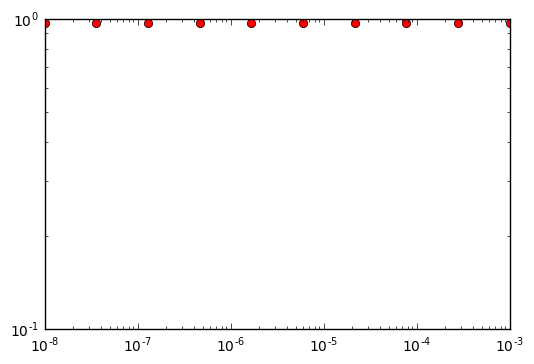

In [199]:
y = []

num=pd.Series(np.zeros(df.shape[0]))
den=pd.Series(np.zeros(df.shape[0]))
if 'Hm_2 ->  MU+ NUT' in df:
    num = num+df['Hm_2 ->  MU+ NUT']    
if 'Hm_2 ->  MU+ NUM' in df:
    num=num+df['Hm_2 ->  MU+ NUM']
if 'Hm_2 ->  MU+ NUE' in df:
    num=num+df['Hm_2 ->  MU+ NUE']
    
if 'Hm_2 ->  TAUden.shape[0]:+ NUT' in df:
    den = den+df['Hm_2 ->  TAU+ NUT']
if 'Hm_2 ->  TAU+ NUM' in df:
    den=den+df['Hm_2 ->  TAU+ NUM']
if 'Hm_2 ->  TAU+ NUE' in df:
    den=den+df['Hm_2 ->  TAU+ NUE']
if den.unique()[0]:
    y = num/den
else:
    sys.exit('ERROR: No branchings')

#plt.plot(df.epsE33,y,'ro')
plt.loglog(df.epsE33,y,'ro')

In [200]:
print df.Fv1, df.Fv2, df.Fv3



0   -1.653177e-12
1   -1.664098e-12
2   -1.704259e-12
3   -1.835759e-12
4   -2.192228e-12
5   -2.627318e-12
6   -2.295180e-12
7   -1.266279e-12
8   -5.029918e-13
9   -1.925559e-13
Name: Fv1, dtype: float64 0   -8.001270e-12
1   -8.023455e-12
2   -8.101386e-12
3   -8.396010e-12
4   -9.575604e-12
5   -1.472583e-11
6   -3.566363e-11
7   -1.130682e-10
8   -3.923670e-10
9   -1.396564e-09
Name: Fv2, dtype: float64 0    5.226864e-11
1    5.230174e-11
2    5.241984e-11
3    5.284596e-11
4    5.438202e-11
5    5.996734e-11
6    8.057300e-11
7    1.569486e-10
8    4.354842e-10
9    1.439371e-09
Name: Fv3, dtype: float64


In [201]:
print np.sqrt((df.Fv2*df.Fv2)-(df.Fv1*df.Fv1))

0    7.828622e-12
1    7.848987e-12
2    7.920098e-12
3    8.192861e-12
4    9.321284e-12
5    1.448955e-11
6    3.558970e-11
7    1.130611e-10
8    3.923667e-10
9    1.396564e-09
dtype: float64


In [202]:
print np.sqrt((df.Fv3*df.Fv3)-(df.Fv1*df.Fv1))

0    5.224249e-11
1    5.227526e-11
2    5.239212e-11
3    5.281406e-11
4    5.433782e-11
5    5.990975e-11
6    8.054031e-11
7    1.569435e-10
8    4.354839e-10
9    1.439371e-09
dtype: float64


In [113]:
Dm21 = np.sqrt(7.5e-5)*1e-9
print Dm21

Dm31 = np.sqrt(2.524e-3)*1e-9
print Dm31

8.66025403784e-12
5.02394267483e-11


[![Home](http://www.incredimail.com/images/nav%20bar/home-icon.png)](./) 
[Jupyter home](./draft.pdf)